Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Exercise03

## Problem

In the last exercise, you used tabular analyses to examine how eviction impacts tenants in Montgomery and Prince George's Counties. In this exercise, you will use more precise, address-level data to analyze evictions across the entire state through a spatial lens.

**You get to write your own research question, but with a few parameters:**
- It should be addressable with the provided eviction data
- It should require that you relate the eviction data to at least one other dataset, which you provide
- It should involve at least one form of spatial analysis (e.g., proximity, overlay, or measurement of another spatial relationship)

**Please write a short abstract (200-300 words) at the top of your exercise notebook that concisely summarizes your research question, how you addressed it, and the results of your analysis. Then provide reproducible code in cells below.**

### Bonus

Only a portion of the eviction records I'm providing for this exercise have addresses that can be geocoded (converting address strings to geographic coordinates) with a high degree of accuracy, or even at all. How could you assess bias in which records are accurately geocoded? (Hint: This will require you to define accuracy.) Can you write a Python script that evaluates whether higher- and lower-accuracy geocodes are randomly distributed across eviction records, or whether certain types of evictions are more or less likely to be geocoded well? **Please report your approach and findings in a separate paragraph and provide supporting code.**

## Data

[Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing)

I'm providing you with eviction warrant data for the whole state of Maryland from 2022 through December 2024. These are from the same District Court of Maryland and Department of Housing and Community Development (DHCD) [source](https://app.powerbigov.us/view?r=eyJrIjoiYWI1Yzg0YjYtNDFkZS00MDUyLThlMDctYmE1ZjY5MGI0MWJhIiwidCI6IjdkM2I4ZDAwLWY5YmUtNDZlNy05NDYwLTRlZjJkOGY3MzE0OSJ9&pageName=ReportSection) as the data from Exercise 2, but also include street addresses. While these data are technically public, it is best practice not to store address-level data on a public GitHub repository. It is also a best practice not to commit large raw data files to Git. For both these reasons, I have shared this dataset in a [Google Drive](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing) folder to which your UMD account has been invited. You should download `md_eviction_warrants_through_2024.csv` store it in the exercise03 directory on your computer before starting to code. 

There is a `.gitignore` file in the exercise03 directory that prevents any `.csv` file from being tracked by Git. As long as you don't modify this `.gitignore`, the raw data file won't get committed, pushed to your remote fork, or included in a pull request back to the course repo.

## File Management and Submitting
To submit, please:
1. Make a new branch on your fork for this exercise.
2. Make a notebook for your exercise with your first name as an underscored suffix (e.g., `exercise02_chester.ipynb`)
    - You can either copy this notebook to work off of or start with a fresh notebook. Your choice.
4. Make commits to that branch as you work on the exercise.
5. Don't commit the eviction warrant CSV or other raw data files to Git.
    - Instead, please add any other raw data files your analysis depends on the [Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing).
    - The current `.gitignore` will prevent CSV files from committing. Add additional file names/extensions as necessary.
6. Make a pull request from your branch. Ensure that the only files included in your pull request are those you intended for this exercise.

## Getting Started
To get started, here's some code I developed for geocoding the address in each eviction warrant into a geographic coordinate. You can include all or parts of this code in your own exercise, or just run this notebook to produce the `md_eviction_warrants_through_2024.geoparquet` file and import it into your own notebook to use the results.

### U.S. Census Geocoder
This geocoding process makes use of a [free geocoder provided by the US Census](https://geocoding.geo.census.gov/geocoder/). It's not the most accurate geocoder available, but it's free and fast.

### Breaking Code Into Modules
In this geocoding process, I'm demonstrating an approach to coding where you break code up into multiple modules and then import names between modules. This helps keep things tidy, allows you to easily reuse code that's generalizable between applications (e.g., the `utils.py` module here), and organize code used for more specific purposes (e.g., the `exercise03.py` and `census_geocode.py` modules).

This is exactly how packages work——modules are the basic building blocks. If you wrote an interconnected set of modules to address a certain problem space, you could publish it as a package and let others download it with conda or pip. That's how open-source software gets its start!

In [1]:
import pandas as pd
import geopandas as gpd
import utils
import exercise03
import census_geocode

%load_ext autoreload
%autoreload 2

In [2]:
# Load warrants and make sure zip codes are stored as strings without decimals
warrants_df = pd.read_csv('md_eviction_warrants_through_2024.csv')
warrants_df['TenantZipCode'] = warrants_df['TenantZipCode'].astype('Int64').astype('string')
len(warrants_df) # How many warrants are we working with?

411040

In [3]:
# Rather than geocoding 400K+ addresses, could we get only the unique ones?
geocode_input_df = exercise03.prep_warrants_for_geocoding(warrants_df)

411040 warrants input
Reduced to 167949 unique addresses


In [4]:
# The Census Geocoder API can only accept up to 10K rows at a time, so we have to break
# our dataframe into chunks

# Split into dataframes with less than 10K rows each
geocode_input_dfs = utils.chunk_dataframe(geocode_input_df, 9999)

# Save each dataframe as a CSV without a header
utils.save_dfs_to_csv(geocode_input_dfs, 'geocode_inputs', header=False)

split dataframe into 17 chunks


In [5]:
# Geocode addresses with the Census Geocoder (set test=True to process only one file)
census_geocode.geocode_csvs('geocode_inputs', 'geocode_outputs', test=True)

TEST MODE: Processing only one file.
Processing file: geocode_inputs/df_14.csv
Saved results to: geocode_outputs/geocoderesult_df_14.csv


In [6]:
# Recombine outputs from geocoder into a single dataframe
geocode_output_df = exercise03.combine_census_geocoded_csvs('geocode_outputs')
len(geocode_output_df)

167949

In [7]:
# Merge geocoded address back onto the inputs with separate fields for address, city, state, and zip
geocoded_df = geocode_input_df.merge(geocode_output_df, left_index=True, right_index=True)
len(geocoded_df)

167949

In [8]:
# Use address, city, state, and zip columns to join geocodes onto original warrant records
warrants_df = warrants_df.merge(geocoded_df, on=['TenantAddress','TenantCity','TenantState','TenantZipCode'])
len(warrants_df)

411040

In [9]:
# Convert warrants into a geodataframe with points
warrants_gdf = utils.lonlat_str_to_geodataframe(warrants_df, 'match_lon_lat')

In [10]:
# What proportion of records have points?
len(warrants_gdf[warrants_gdf.lon.notnull()]) / len(warrants_gdf)

0.9458057609964967

In [11]:
# What proportion of records have exact geocode matches?
len(warrants_gdf[warrants_gdf.match_type == 'Exact']) / len(warrants_gdf)

0.5598554885169327

Parquet is a file format for tabular data that efficiently stores data of many types, including a 'geoparquet' variant that stores geometries like points, lines, and polygons. You can easily save a dataframe or geodataframe to parquet with the `.to_parquet` method. The resulting file will be much smaller and load faster than more convetional formats, such as CSV or shapefile. The downside is that you won't be able to open it with Excel, ArcGIS, or other conventional desktop software.

In [12]:
warrants_gdf.to_parquet('md_eviction_warrants_through_2024.geoparquet')

You can load a parquet file back to a dataframe with `pd.read_parquet('filename')` or a geoparquet back to a geodataframe with `gpd.read_parquet('filename')`

In [13]:
gdf = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

In [15]:
gdf.columns.tolist()

['ID',
 'EventDate',
 'EventType',
 'EventComment',
 'County',
 'Location',
 'TenantAddress',
 'TenantCity',
 'TenantState',
 'TenantZipCode',
 'CaseType',
 'CaseNumber',
 'EvictedDate',
 'Source',
 'SourceDate',
 'Year',
 'EvictionYear',
 'unique_id',
 'input_address',
 'match_status',
 'match_type',
 'match_address',
 'match_lon_lat',
 'match_tiger_line_id',
 'match_tiger_line_side',
 'lon',
 'lat',
 'geometry']

### Sam's Research Question: Which census tracts in Maryland have the highest eviction rates, and how do eviction rates vary across the state when normalized by population?

This analysis explores the spatial distribution of eviction rates across Census tracts in Maryland, with a focus on identifying geographic patterns and areas of concentrated housing instability. Using the provided Maryland eviction filing data and American Community Survey (ACS) population estimates by census tract, we calculated tract-level eviction rates by dividing the number of filings by the total population in each tract. These rates were then visualized using geospatial analysis tools in Python, including GeoPandas and Matplotlib.

To enhance legibility and focus on areas with more significant eviction activity, tracts with zero eviction rates were filtered out, followed by a secondary filter highlighting tracts with eviction rates greater than 1%. The resulting maps, stylized using colormaps and basemaps from Contextily, reveal clear spatial disparities, with clusters of high eviction rates appearing in specific urban and suburban areas. 

This exercise demonstrates the value of integrating spatial data with Python-based geospatial analysis for identifying vulnerable communities and informing policy responses. Future iterations of this work could incorporate additional contextual data—such as rent burden, public transit access, or zoning type—to deepen understanding of the drivers of eviction and support targeted intervention strategies.


In [2]:
import geopandas as gpd

# Loading MD Census Tract + Population Data
tracts = gpd.read_file("md_censustracts.geojson")
tracts.head()

,geoid,name,B01003001,"B01003001, Error",geometry
0,14000US24001000100,"Census Tract 1, Allegany, MD",3153.0,429.0,"MULTIPOLYGON (((-78.66648 39.64913, -78.66643 ..."
1,14000US24001000200,"Census Tract 2, Allegany, MD",4094.0,329.0,"MULTIPOLYGON (((-78.77825 39.6019, -78.77774 3..."
2,14000US24001000500,"Census Tract 5, Allegany, MD",2269.0,315.0,"MULTIPOLYGON (((-78.75859 39.6523, -78.7585 39..."
3,14000US24001000600,"Census Tract 6, Allegany, MD",2829.0,351.0,"MULTIPOLYGON (((-78.76322 39.64254, -78.76251 ..."
4,14000US24001000700,"Census Tract 7, Allegany, MD",3377.0,442.0,"MULTIPOLYGON (((-78.76502 39.63272, -78.76492 ..."


<Axes: >

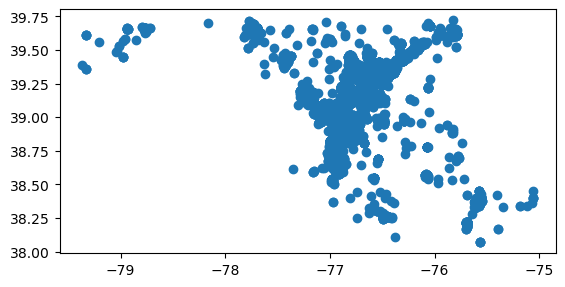

In [4]:
# Let's see what the evictions look like when plotted
evictions = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')
evictions.plot()

In [5]:
# Confirm both GDFs use the same Coordinate Reference System (CRS)
print("Evictions CRS:", evictions.crs)
print("Tracts CRS:", tracts.crs)

# Confirmed: Both GDFs use EPSG:4326

Evictions CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal component of 3D system.", "area"

In [6]:
# Spatial join to attach each Eviction point to the Tract polygon it falls within
evictions_with_tracts = gpd.sjoin(evictions, tracts, how="left", predicate="within")
evictions_with_tracts.head()

    # 'how="left"' = attach tract info to eviction dataset row whenever there is a match
    # 'predicate="within" = only match if the eviction point is inside the tract polygon

,ID,EventDate,EventType,EventComment,County,Location,TenantAddress,TenantCity,TenantState,TenantZipCode,...,match_tiger_line_id,match_tiger_line_side,lon,lat,geometry,index_right,geoid,name,B01003001,"B01003001, Error"
0,1.0,1/17/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,10 Light St Apt 1422,Baltimore,MD,21202,...,206456013.0,R,-76.5500005941,39.320205069206,POINT (-76.55 39.32021),1408.0,14000US24510260203,"Census Tract 2602.03, Baltimore, MD",2670.0,341.0
1,2.0,1/23/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,5543 Force Rd,Baltimore,MD,21206,...,618593150.0,L,-76.795057124575,39.107342365173,POINT (-76.79506 39.10734),122.0,14000US24003740502,"Census Tract 7405.02, Anne Arundel, MD",4933.0,724.0
2,3.0,8/17/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,2418 Marbourne Ave #3B,Baltimore,MD,21230,...,618593150.0,L,-76.795057124575,39.107342365173,POINT (-76.79506 39.10734),122.0,14000US24003740502,"Census Tract 7405.02, Anne Arundel, MD",4933.0,724.0
3,4.0,8/19/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,2502 W Patapsco #3D,Baltimore,MD,21230,...,NaN,None,None,None,POINT EMPTY,NaN,NaN,NaN,NaN,NaN
4,5.0,9/9/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,611 S Charles St #361,Baltimore,MD,21230,...,618593150.0,L,-76.795057124575,39.107342365173,POINT (-76.79506 39.10734),122.0,14000US24003740502,"Census Tract 7405.02, Anne Arundel, MD",4933.0,724.0


In [8]:
# Count number of evictions in each census tract
eviction_counts = evictions_with_tracts.groupby("geoid").size().reset_index(name="eviction_count")
eviction_counts.head()

,geoid,eviction_count
0,14000US24001000500,3
1,14000US24001000600,4
2,14000US24001000700,8
3,14000US24001000800,4
4,14000US24001001000,8


In [13]:
# Merge eviction counts into tracts GDF using the geoid (census tract identifier) as the key
tracts_with_evictions = tracts.merge(eviction_counts, on="geoid", how="left")

# Fill in a '0' for tracts with no evictions
tracts_with_evictions["eviction_count"] = tracts_with_evictions["eviction_count"].fillna(0)

# Calculate eviction_rate as evictions/population
tracts_with_evictions["eviction_rate"] = tracts_with_evictions["eviction_count"] / tracts_with_evictions["B01003001"]

# Preview data
tracts_with_evictions[["geoid", "name", "eviction_rate"]].head()


,geoid,name,eviction_rate
0,14000US24001000100,"Census Tract 1, Allegany, MD",0.000000
1,14000US24001000200,"Census Tract 2, Allegany, MD",0.000000
2,14000US24001000500,"Census Tract 5, Allegany, MD",0.001322
3,14000US24001000600,"Census Tract 6, Allegany, MD",0.001414
4,14000US24001000700,"Census Tract 7, Allegany, MD",0.002369


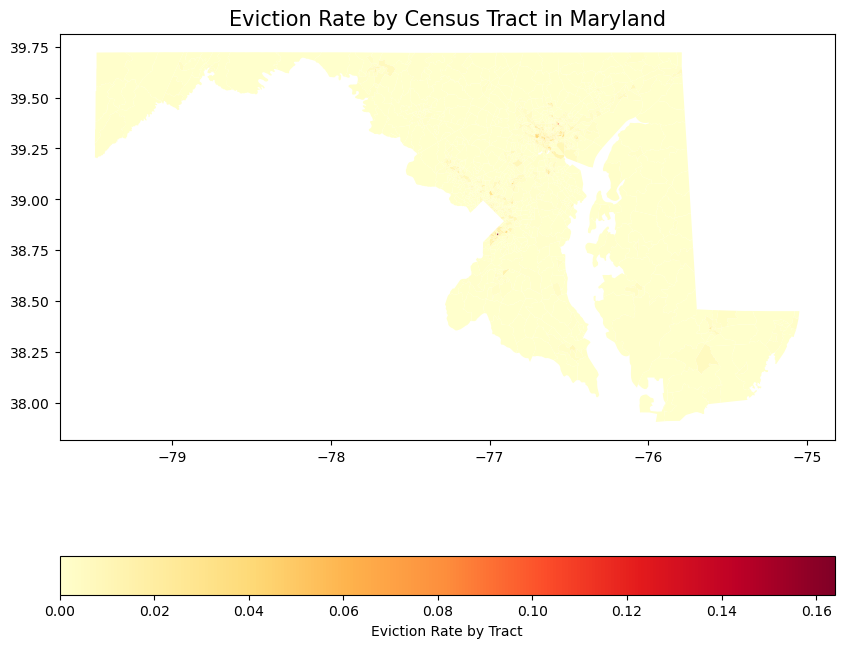

In [15]:
import matplotlib.pyplot as plt

# Creating a Choropleth Map

# Plot the tracts with eviction rate
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the tracts, with color based on the eviction rate
tracts_with_evictions.plot(column="eviction_rate", 
                           ax=ax, 
                           legend=True,
                           cmap="YlOrRd",  # Color map (yellow to red)
                           legend_kwds={'label': "Eviction Rate by Tract",
                                        'orientation': "horizontal"})

# Set plot title
ax.set_title("Eviction Rate by Census Tract in Maryland", fontsize=15)

# Show the map
plt.show()


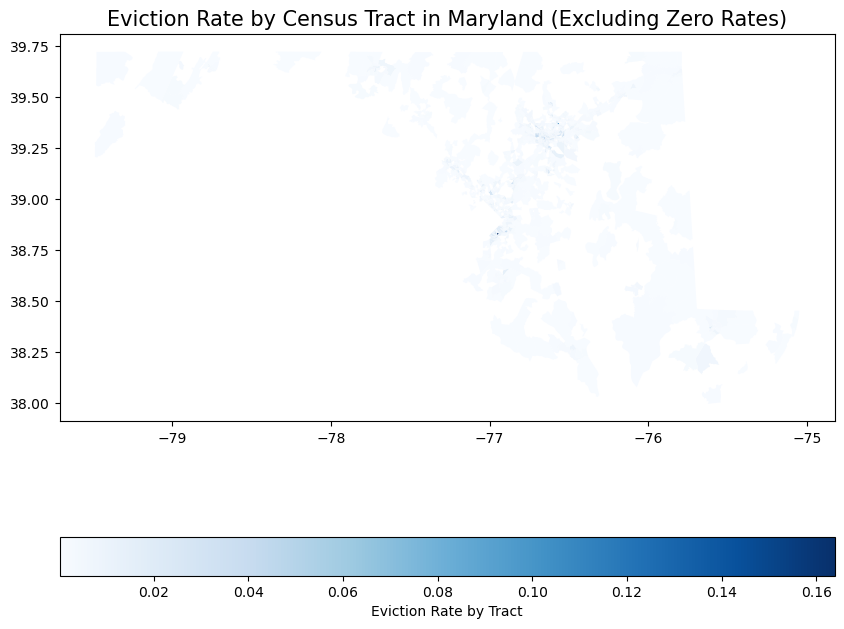

In [66]:
# Filter out tracts with zero eviction rate for increased legibility (and trying blue color instead)
tracts_with_evictions_filtered = tracts_with_evictions[tracts_with_evictions["eviction_rate"] > 0.0]

# Plot the filtered tracts with eviction rate
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the tracts with eviction rates greater than 0
tracts_with_evictions_filtered.plot(column="eviction_rate", 
                                     ax=ax, 
                                     legend=True,
                                     cmap="Blues",  # Using blue gradient instead
                                     legend_kwds={'label': "Eviction Rate by Tract",
                                                  'orientation': "horizontal"})

# Set plot title
ax.set_title("Eviction Rate by Census Tract in Maryland (Excluding Zero Rates)", fontsize=15)

# Show the map
plt.show()


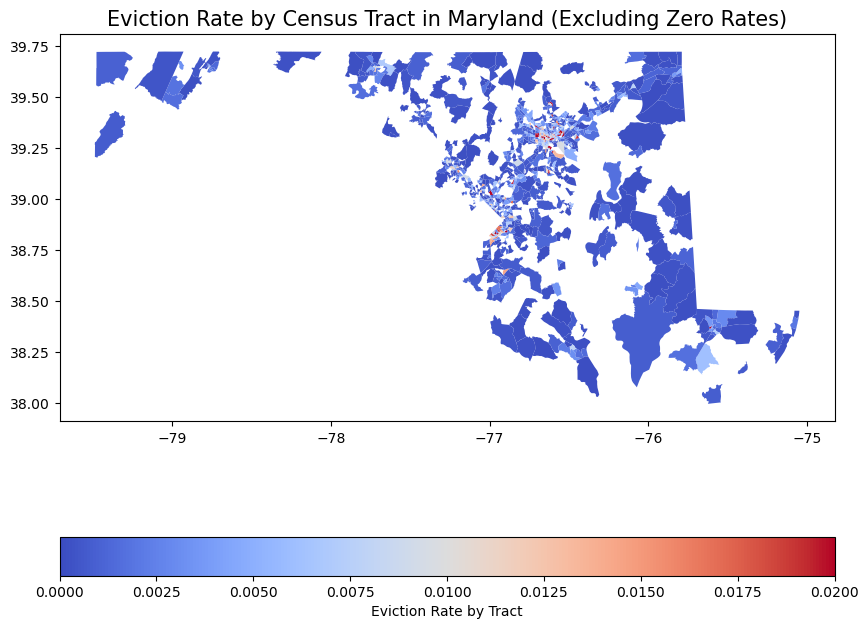

In [68]:
# Plot with a different color map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot using a new color map
tracts_with_evictions_filtered.plot(column="eviction_rate", 
                                     ax=ax, 
                                     legend=True,
                                     cmap="coolwarm",  # Trying out Cool vs. Warm color map
                                     vmin=0, 
                                     vmax=0.02,  
                                     legend_kwds={'label': "Eviction Rate by Tract",
                                                  'orientation': "horizontal"})

# Set plot title
ax.set_title("Eviction Rate by Census Tract in Maryland (Excluding Zero Rates)", fontsize=15)

# Show the map
plt.show()


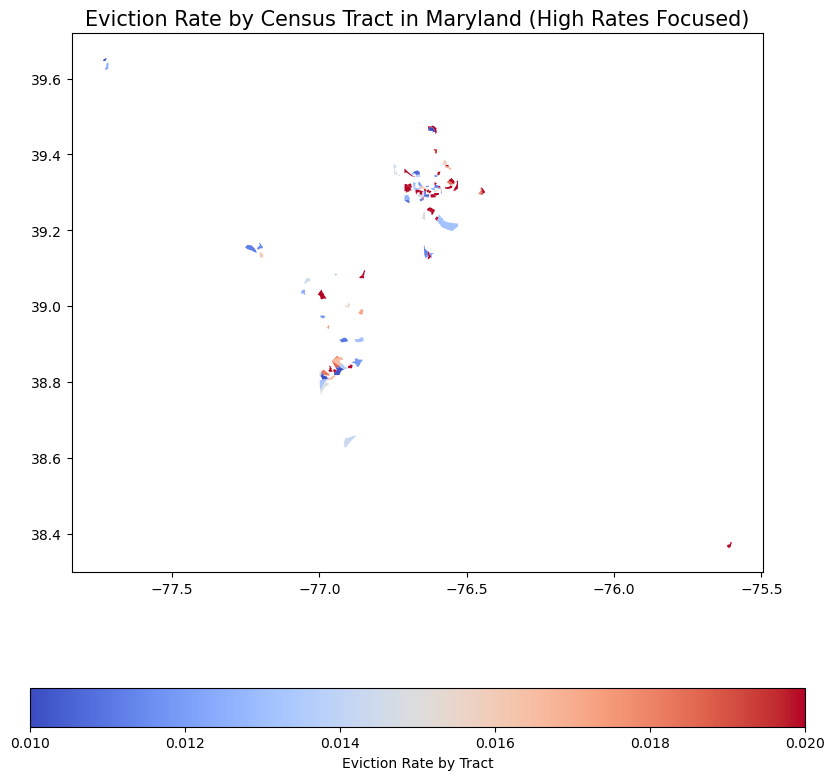

In [76]:
# Filter out areas with very low eviction rates (less than 0.01) for increased legibility 
tracts_with_evictions_filtered_high_rate = tracts_with_evictions_filtered[tracts_with_evictions_filtered["eviction_rate"] > 0.01]

# Plot the high-rate areas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

tracts_with_evictions_filtered_high_rate.plot(column="eviction_rate", 
                                               ax=ax, 
                                                 legend=True,
                                                 cmap="coolwarm",  
                                                 vmin=0.01, 
                                                 vmax=0.02,  
                                                 legend_kwds={'label': "Eviction Rate by Tract",
                                                              'orientation': "horizontal"})

# Set plot title
ax.set_title("Eviction Rate by Census Tract in Maryland (High Rates Focused)", fontsize=15)

# Show the map
plt.show()


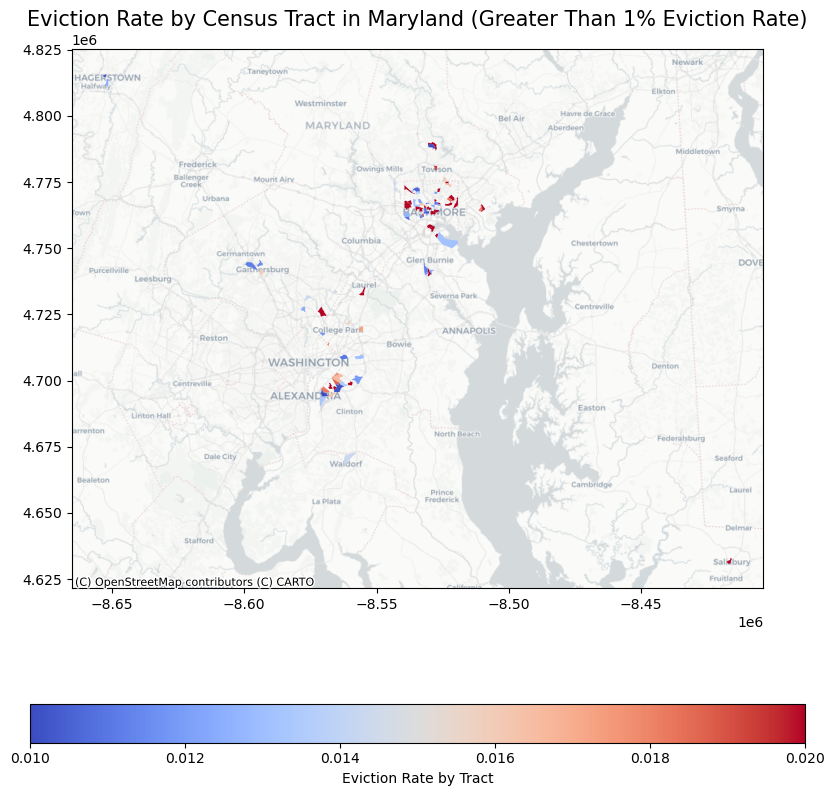

In [62]:
import contextily as ctx
import matplotlib.pyplot as plt

# Using Contextily tool to add basemap from OpenStreetMap for increased legibility

# Filter out areas with very low eviction rates (less than 0.01) for increased legibility 
tracts_with_evictions_filtered_high_rate = tracts_with_evictions_filtered[tracts_with_evictions_filtered["eviction_rate"] > 0.01]

# Ensure data is in EPSG:3857 for compatibility with the basemap
if tracts_with_evictions_filtered.crs != "EPSG:3857":
    tracts_with_evictions_filtered = tracts_with_evictions_filtered.to_crs(epsg=3857)

# Plot the high-rate areas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the data
tracts_with_evictions_filtered_high_rate.plot(column="eviction_rate", 
                                               ax=ax, 
                                               legend=True,
                                               cmap="coolwarm",  
                                               vmin=0.01, 
                                               vmax=0.02, 
                                               legend_kwds={'label': "Eviction Rate by Tract",
                                                            'orientation': "horizontal"})

# URL for OpenStreetMap tiles
osm_url = "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png"

# Add the basemap with the custom URL
ctx.add_basemap(ax, crs=tracts_with_evictions_filtered.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set plot title
ax.set_title("Eviction Rate by Census Tract in Maryland (Greater Than 1% Eviction Rate)", fontsize=15)

# Show the map
plt.show()


### Conclusion: Census tracts with higher eviction rates can mostly be found in Baltimore City and in Prince George's County to the southeast of Washington, DC. 

In [80]:
# Sort the tracts by eviction rate in descending order
top_10_tracts = tracts_with_evictions.sort_values(by="eviction_rate", ascending=False).head(10)

# Display selected columns for clarity
top_10_tracts[["geoid", "name", "eviction_rate"]]


,geoid,name,eviction_rate
1024,14000US24033801801,"Census Tract 8018.01, Prince George's, MD",0.163894
1434,14000US24510270701,"Census Tract 2707.01, Baltimore, MD",0.104801
1467,14000US24510280301,"Census Tract 2803.01, Baltimore, MD",0.040075
1039,14000US24033802106,"Census Tract 8021.06, Prince George's, MD",0.039819
1359,14000US24510160500,"Census Tract 1605, Baltimore, MD",0.037064
941,14000US24033800210,"Census Tract 8002.10, Prince George's, MD",0.036336
1414,14000US24510260403,"Census Tract 2604.03, Baltimore, MD",0.033778
72,14000US24003730511,"Census Tract 7305.11, Anne Arundel, MD",0.033715
1464,14000US24510280101,"Census Tract 2801.01, Baltimore, MD",0.031465
1339,14000US24510140200,"Census Tract 1402, Baltimore, MD",0.031447
